In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from scipy import signal
import matplotlib.gridspec as gridspec
from skimage.draw import disk 
%matplotlib inline

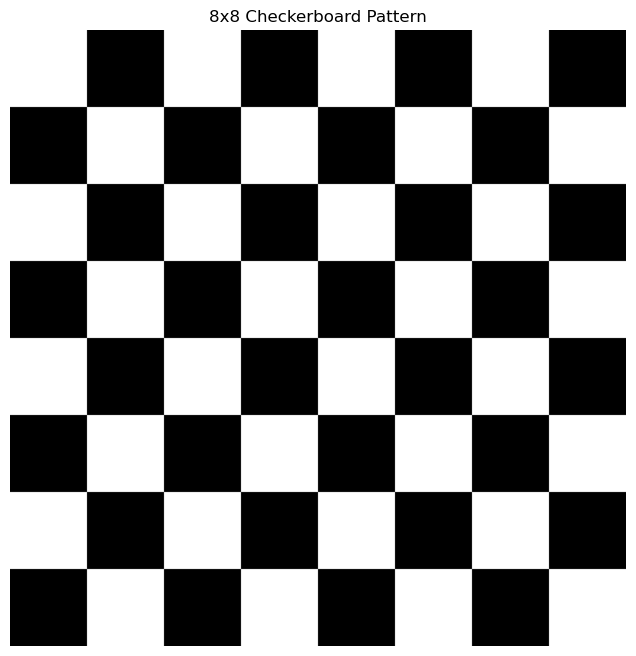

In [9]:
# Create 8x8 checkerboard
checkerboard_size = 8
square_size = 50  
img_size = checkerboard_size * square_size

# Create the checkerboard pattern using numpy only
checkerboard = np.kron(
    [[1, 0] * (checkerboard_size//2), [0, 1] * (checkerboard_size//2)] * (checkerboard_size//2),
    np.ones((square_size, square_size)))
checkerboard = (checkerboard * 255).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(checkerboard, cmap='gray')
plt.title('8x8 Checkerboard Pattern')
plt.axis('off')
plt.show()

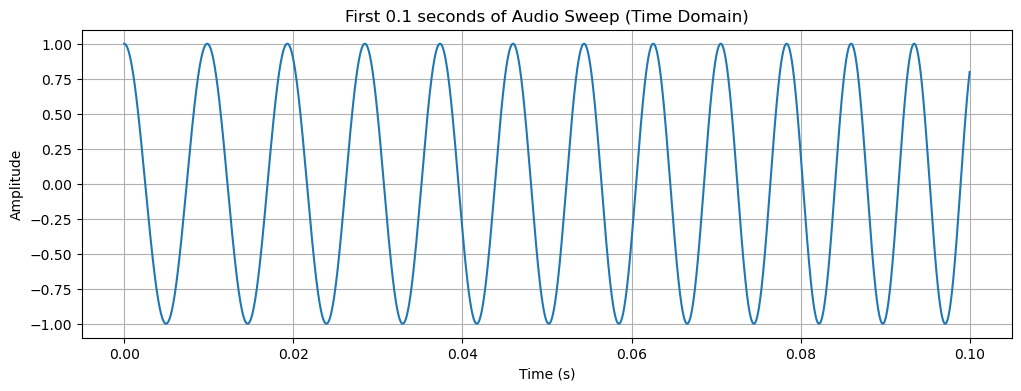

In [11]:
# Audio parameters
sample_rate = 44100
duration = 5.0       
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Create frequency sweep (chirp signal)
start_freq = 100
end_freq = 2000
audio_sweep = signal.chirp(t, f0=start_freq, t1=duration, f1=end_freq, method='linear')

# Normalize to 16-bit range for playback
audio_sweep_int = np.int16(audio_sweep * 32767)

display(Audio(audio_sweep_int, rate=sample_rate))

plt.figure(figsize=(12, 4))
plt.plot(t[:int(0.1*sample_rate)], audio_sweep[:int(0.1*sample_rate)])
plt.title('First 0.1 seconds of Audio Sweep (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

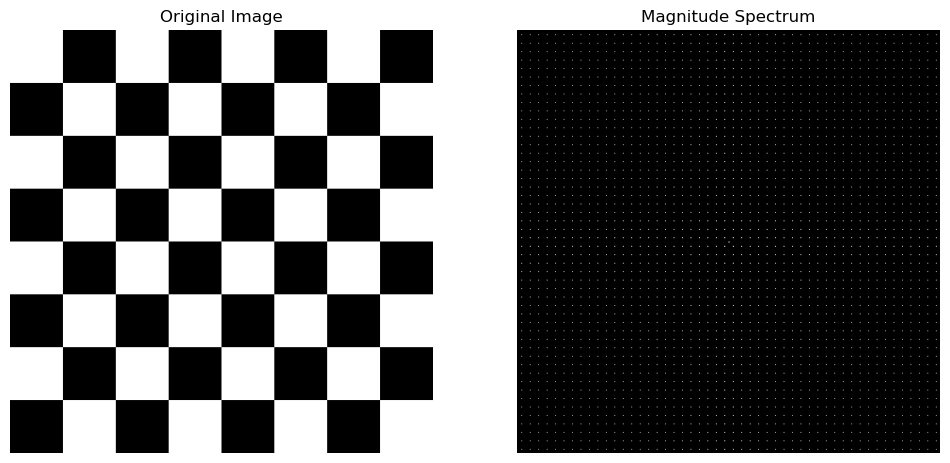

In [13]:
# Compute 2D Fourier Transform of the checkerboard
fft_img = np.fft.fft2(checkerboard)
fft_shift = np.fft.fftshift(fft_img)
magnitude_spectrum = 20 * np.log(np.abs(fft_shift) + 1)  

plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(checkerboard, cmap='gray')
plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.axis('off')
plt.show()

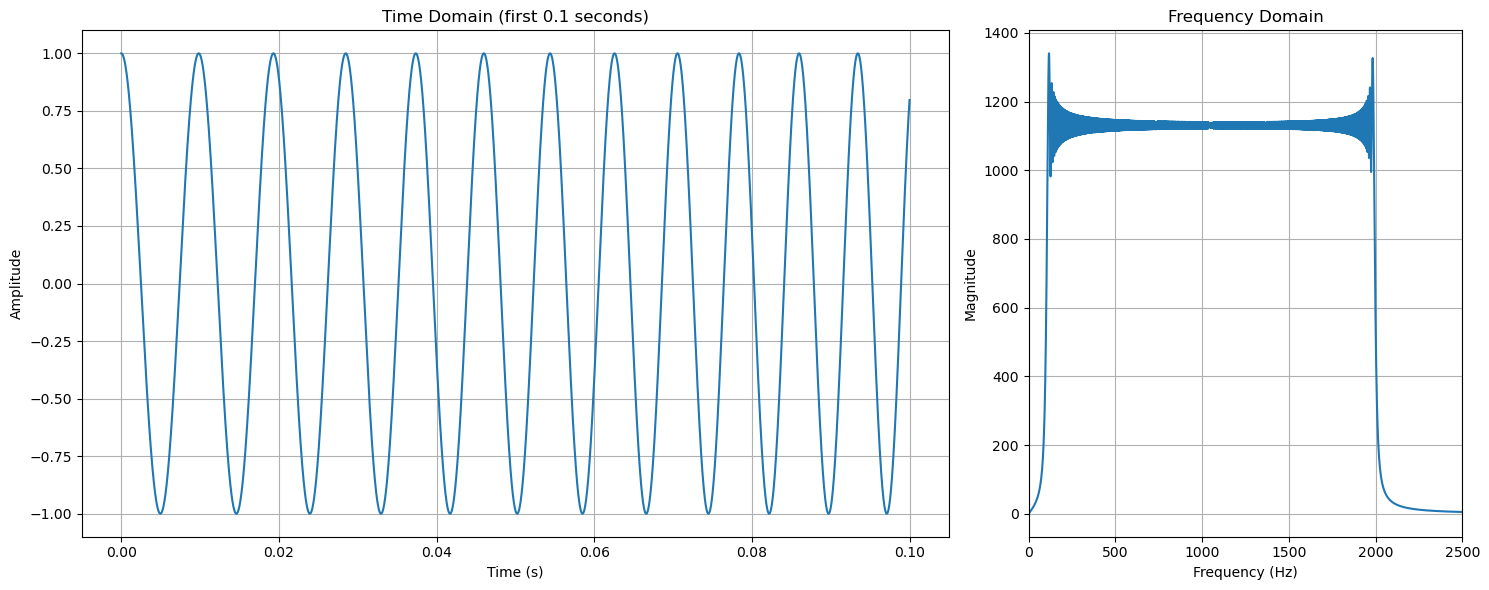

In [15]:
# Compute FFT of the entire audio signal
n = len(audio_sweep)
freqs = np.fft.fftfreq(n, d=1/sample_rate)
fft_audio = np.fft.fft(audio_sweep)
magnitude = np.abs(fft_audio)

# Plot time and frequency domains
plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

# Time domain (zoomed in)
plt.subplot(gs[0])
plt.plot(t[:int(0.1*sample_rate)], audio_sweep[:int(0.1*sample_rate)])
plt.title('Time Domain (first 0.1 seconds)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

# Frequency domain
plt.subplot(gs[1])
positive_freqs = freqs[:n//2]
positive_magnitude = magnitude[:n//2]
plt.plot(positive_freqs, positive_magnitude)
plt.title('Frequency Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 2500)
plt.grid()

plt.tight_layout()
plt.show()

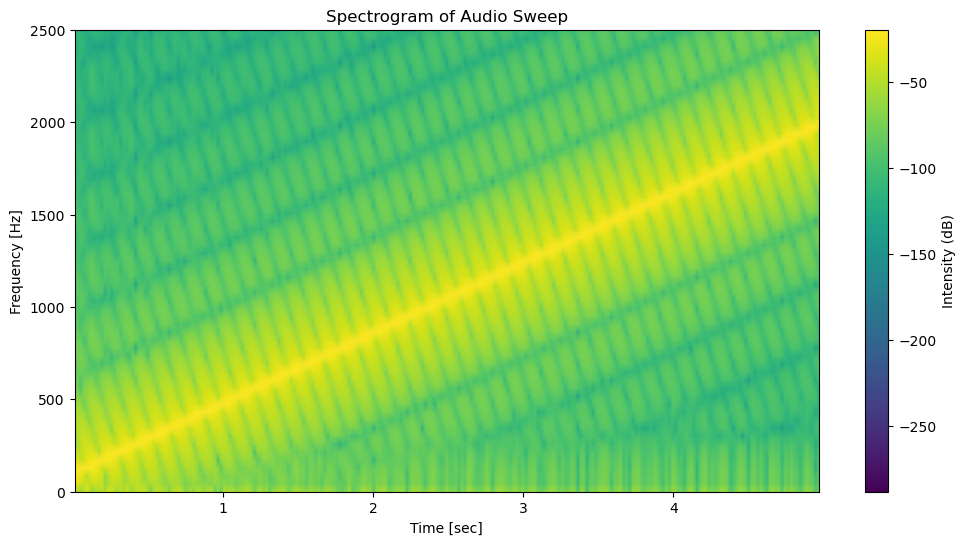

In [17]:
# Compute and display spectrogram
plt.figure(figsize=(12, 6))
f, t_spec, Sxx = signal.spectrogram(audio_sweep, sample_rate, nperseg=1024)
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity (dB)')
plt.title('Spectrogram of Audio Sweep')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2500)
plt.show()

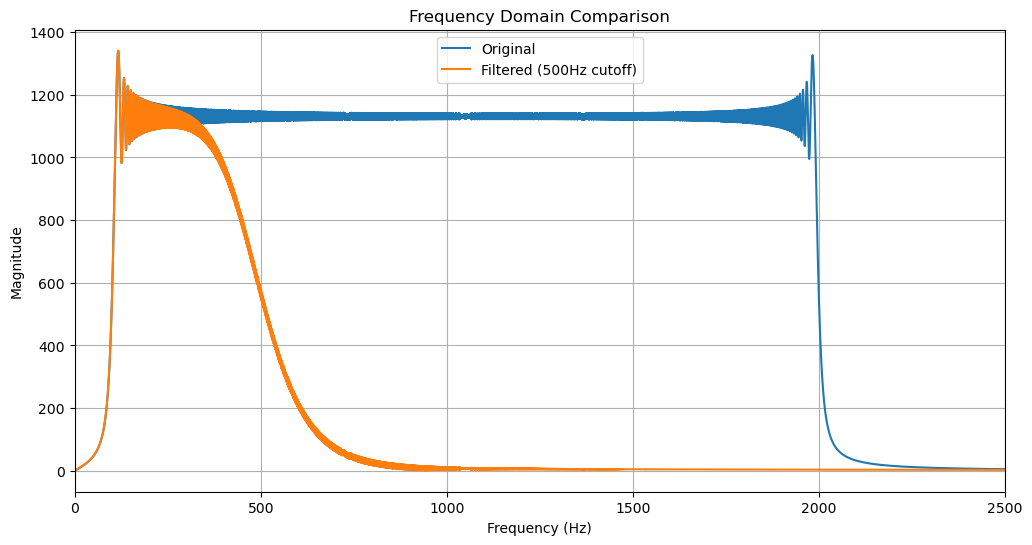

In [19]:
# Design a low-pass filter
nyquist = 0.5 * sample_rate
cutoff = 500  # Hz
b, a = signal.butter(4, cutoff/nyquist, btype='low')

filtered_audio = signal.filtfilt(b, a, audio_sweep)

# Compute FFT of filtered audio
fft_filtered = np.fft.fft(filtered_audio)
magnitude_filtered = np.abs(fft_filtered)

plt.figure(figsize=(12, 6))
plt.plot(freqs[:n//2], magnitude[:n//2], label='Original')
plt.plot(freqs[:n//2], magnitude_filtered[:n//2], label='Filtered (500Hz cutoff)')
plt.title('Frequency Domain Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 2500)
plt.legend()
plt.grid()
plt.show()


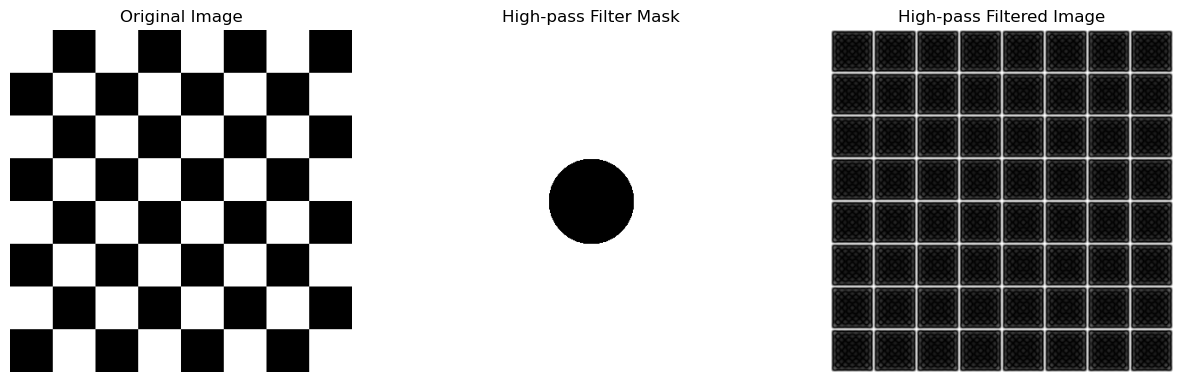

In [21]:
# Create a high-pass filter for the image using scikit-image
rows, cols = checkerboard.shape
crow, ccol = rows // 2, cols // 2

# Create a circular mask using scikit-image
mask = np.ones((rows, cols), dtype=bool)
rr, cc = disk((crow, ccol), radius=50, shape=checkerboard.shape)
mask[rr, cc] = False

# Apply mask and inverse DFT
fshift = fft_shift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

# Display results
plt.figure(figsize=(15, 6))
plt.subplot(131), plt.imshow(checkerboard, cmap='gray')
plt.title('Original Image'), plt.axis('off')
plt.subplot(132), plt.imshow(mask, cmap='gray')
plt.title('High-pass Filter Mask'), plt.axis('off')
plt.subplot(133), plt.imshow(img_back, cmap='gray')
plt.title('High-pass Filtered Image'), plt.axis('off')
plt.show()

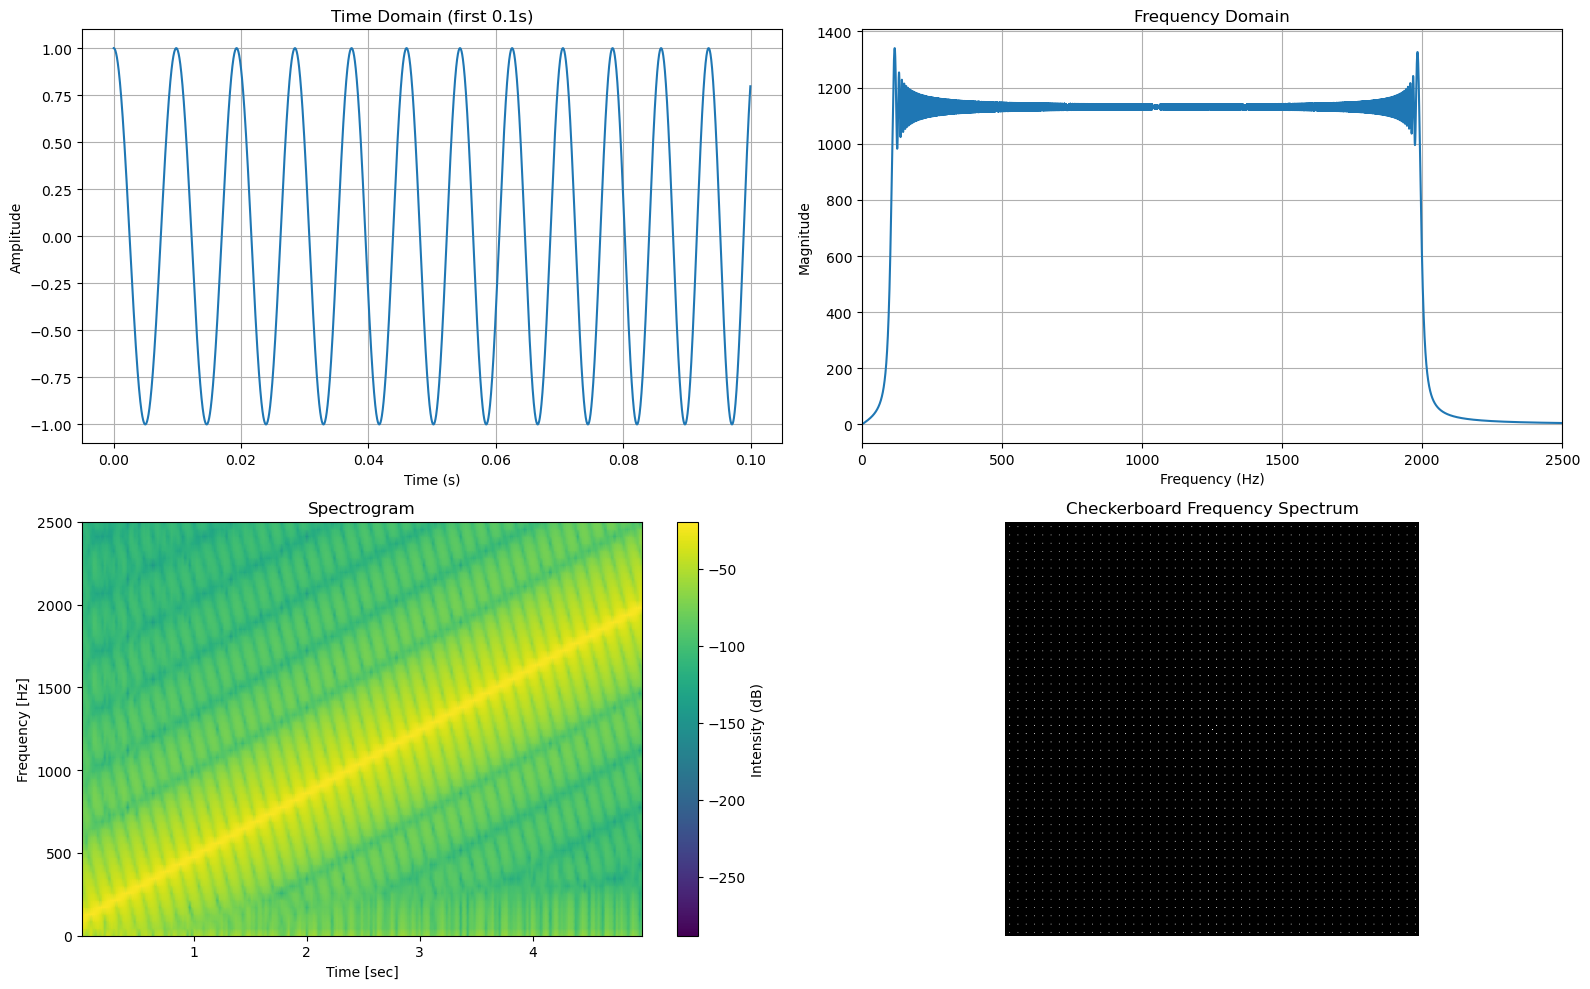

In [23]:
# Create a figure to compare all representations
plt.figure(figsize=(16, 10))

# Original audio time domain
plt.subplot(2, 2, 1)
plt.plot(t[:int(0.1*sample_rate)], audio_sweep[:int(0.1*sample_rate)])
plt.title('Time Domain (first 0.1s)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

# Frequency domain
plt.subplot(2, 2, 2)
plt.plot(positive_freqs, positive_magnitude)
plt.title('Frequency Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 2500)
plt.grid()

# Spectrogram
plt.subplot(2, 2, 3)
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity (dB)')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2500)

# Checkerboard spectrum
plt.subplot(2, 2, 4)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Checkerboard Frequency Spectrum')
plt.axis('off')

plt.tight_layout()
plt.show()